# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import Analysis
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
#COLOR = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown', 'darkred','red']
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN']#,'YK']

nb_sujet = len(list_sujet)

COLOR = []
for n in range(nb_sujet) :
    COLOR.append((0+(1/nb_sujet)*n, 0, 0, 0.5))

In [5]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [6]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'parametre/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

In [7]:
BET = {}
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            BET[liste[x][1]] = b

# Scaling Data

In [8]:
e = Analysis(observer='AM', mode='enregistrement')
Full = e.Full_list(modes_bcp=None)

In [9]:
scal_va_sujet, scal_va_full = {}, []
scal_bet_sujet, scal_bet_full = {}, []

va_full = []
bet_full = []
for x in list_sujet :
    bet = []
    for block in range(BET[x]['N_blocks']) :
        bet.extend((BET[x]['results'][:,block]+1)/2)
    
    bet_full.extend(bet)
    va_full.extend(list(Full['va'][Full.sujet==x]))
    
    scal_bet_sujet[x] = np.sort(bet)
    scal_va_sujet[x] = np.sort(list(Full['va'][Full.sujet==x]))

scal_va_full = np.sort(va_full)
scal_bet_full = np.sort(bet_full)

In [10]:
new_proba_full = np.linspace(0,1,len(scal_va_full))

new_va_sujet, new_va_full = {}, {}
new_bet_sujet, new_bet_full = {}, {}


for x in list_sujet :
    N_trials = BET[x]['N_trials']
    
    new_proba_sujet = np.linspace(0, 1, len(scal_va_sujet[x]))
    va_sujet = list(Full['va'][Full.sujet==x])
    
    
    nb_trial = 0
    
    new_va_sujet[x], new_va_full[x] = [], []
    new_bet_sujet[x], new_bet_full[x] = [], []
    
    for block in range(3) :
        new_va_sujet[x].append([])
        new_va_full[x].append([])
        
        new_bet_sujet[x].append([])
        new_bet_full[x].append([])
        
        
        va = va_sujet[nb_trial : N_trials + nb_trial*block]
        bet = (BET[x]['results'][:,block]+1)/2
        
        
        for trial in range(len(va)) :
            p = []
            for t in range(len(scal_va_sujet[x])) :
                if scal_va_sujet[x][t] == va[trial] :
                    p.append(new_proba_sujet[t])
            new_va_sujet[x][block].append(np.mean(p))
            
            p = []
            for t in range(len(scal_va_full)) :
                if scal_va_full[t] == va[trial] :
                    p.append(new_proba_full[t])
            new_va_full[x][block].append(np.mean(p))
       

        for trial in range(len(bet)) :
            p = []
            for t in range(len(scal_bet_sujet[x])) :
                if scal_bet_sujet[x][t] == bet[trial] :
                    p.append(new_proba_sujet[t])
            new_bet_sujet[x][block].append(np.mean(p))

            p = []
            for t in range(len(scal_bet_full)) :
                if scal_bet_full[t] == bet[trial] :
                    p.append(new_proba_full[t])
            new_bet_full[x][block].append(np.mean(p))
    
    
        nb_trial = nb_trial + N_trials

# Variation de h

In [11]:
from lmfit import  Model, Parameters
from lmfit import minimize

In [12]:
def fct_BCP(x, h) :

    p_bar, r_bar, beliefs = bcp.inference(x, h=h, p0=.5, r0=1.)
    p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean', p0=.5, fixed_window_size=40)#, mode='mean')
    
    return p_hat

In [13]:
#def KL_distance(p_data, p_hat):
#    distance = p_hat * np.log2(p_hat) - p_hat * np.log2(p_data)
#    distance += (1-p_hat) * np.log2(1-p_hat) - (1-p_hat) * np.log2(1-p_data)
#    return distance

'''def KL_distance(p_data, p_hat):
    distance = p_data * np.log2(p_data + 1.*(p_data==0.)) - p_data * np.log2(p_hat)
    distance += (1-p_data) * np.log2(1-p_data + 1.*(p_data==1.)) - (1-p_data) * np.log2(1-p_hat)
    
    return distance'''

def KL_distance(p_data, p_hat):
    distance = p_hat * np.log2(p_hat) - p_hat * np.log2(p_data + 1.*(p_data==0.))
    distance += (1-p_hat) * np.log2(1-p_hat) - (1-p_hat) * np.log2(1-p_data + 1.*(p_data==1.))
    return distance

def residual(params, x, data):
    h = params['h']
    model = fct_BCP(x, h)
    
    return KL_distance(data, model)

def fit(h, x, bet, va):
    
    x = np.array(x)
    bet = np.array(bet)
    va = np.array(va)


    params = Parameters()
    params.add('h', value=h, min=0, max=1)

    result_res = minimize(residual, params, args=(x, bet), nan_policy='omit')
    result_v_ant = minimize(residual, params, args=(x, va), nan_policy='omit')
    
    h_bet = result_res.params['h'].value
    h_va = result_v_ant.params['h'].value
    
    return h_bet, h_va

In [14]:
h_bet, h_va = {}, {}

for l in ['pause', 'block', 'sujet'] :
    h_bet[l], h_va[l] = [], []

for x, sujet in enumerate(list_sujet) :

    print(sujet)
    
    prob_sujet, bet_sujet, v_anti_sujet = [], [], []

    p = BET[sujet]['p']
    tau = BET[sujet]['N_trials']/5.
    h = 1./tau 

    for l in ['block', 'pause'] :
        h_bet[l].append([])
        h_va[l].append([])

    for block in range(BET[sujet]['N_blocks']):
        va = new_va_full[sujet][block] #new_va_sujet[x][block]
        bet = new_bet_full[sujet][block] #new_bet_sujet[x][block]
        
        
        prob_block = p[:, block, 0]
        h_b, h_v = fit(h, prob_block, bet, va)

        h_bet['block'][x].append(h_b)
        h_va['block'][x].append(h_v)

        prob_sujet.extend(p[:, block, 0])
        bet_sujet.extend(bet)
        v_anti_sujet.extend(va)
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            va_p = va[liste[a]:liste[a+1]]
            bet_p = bet[liste[a]:liste[a+1]]
            prob_pause = p[liste[a]:liste[a+1], block, 0]
            
            h_b, h_v = fit(h, prob_pause, bet_p, va_p)

            h_bet['pause'][x].append(h_b)
            h_va['pause'][x].append(h_v)
                

    h_b, h_v = fit(h, prob_sujet, bet_sujet, v_anti_sujet)
    h_bet['sujet'].append(h_b)
    h_va['sujet'].append(h_v)

AM
BMC
CS
DC
FM
IP
LB
OP
RS
SR
TN


In [15]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

In [16]:
def regress(ax, p, data, c, minx=0, miny=0, maxx=1, maxy=1, t_label=t_label) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    
    ax.text(maxx-((maxx-minx)/10), miny+((maxy-miny)/10), 'r = %0.3f\np_value = %0.3f'%(r_, p_value), fontsize=t_label/1.2, ha='right', color=c)
    return ax

In [17]:
def scatter_mean(bet, va, titre, maxx=0.55, maxy=0.25, ex=0.02, ey=0.01,
                 ellipse=False, color=False, mean='mean', supp=False, fig_width=10) :
    
    if ellipse is True :
        from matplotlib.patches import Ellipse
    
    fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True) #/(1.6180*1))

    m_bet, m_va = [], []
    for x in range(len(bet)):
        if ellipse is True :
            ells = Ellipse((np.mean(bet[x]), np.mean(va[x])), 2*np.std(bet[x]), 2*np.std(va[x]), 0,
                           color='k', alpha=0.2, clip_box=axs.bbox)
            axs.add_artist(ells)
        
        if mean=='mean' :
            mean_bet = np.mean(bet[x])
            mean_va = np.mean(va[x])
        elif mean=='mediane' :
            mean_bet = np.median(bet[x])
            mean_va = np.median(va[x])           
            
        if color is False :
            c = 'k'
        else :
            c = color[x]
            
        axs.errorbar(mean_bet, mean_va,
                    xerr=np.std(bet[x]), yerr=np.std(va[x]),
                    color=c, fmt='o', elinewidth=2, ms=10, alpha=0.6)
        
        m_bet.append(mean_bet)
        m_va.append(mean_va)

    axs.set_title(titre, fontsize=t_titre)
    axs.set_xlabel('h$_{bet}$', fontsize=t_label)
    axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
    axs.tick_params(axis='both', labelsize=t_label/1.8)
    
    axs.axis([-ex ,maxx+ex,-ey,maxy+ey])
    axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')

    regress(axs, m_bet, m_va, 'r', minx=-ex, miny=-ey, maxx=maxx+ex, maxy=(maxy+ey)/2)
    
    '''if supp is True :
        print(np.argmax(m_bet), exp[np.argmax(m_bet)]['observer'])
        del m_va[np.argmax(m_bet)]
        del m_bet[np.argmax(m_bet)]
        print(np.argmax(m_bet), exp[np.argmax(m_bet)]['observer'])
        del m_va[np.argmax(m_bet)]
        del m_bet[np.argmax(m_bet)]

        regress(axs, m_bet, m_va, 'k', minx=0, miny=maxy/2, maxx=maxx, maxy=maxy)'''
    
    fig.tight_layout()
    plt.show()
    return fig, axs

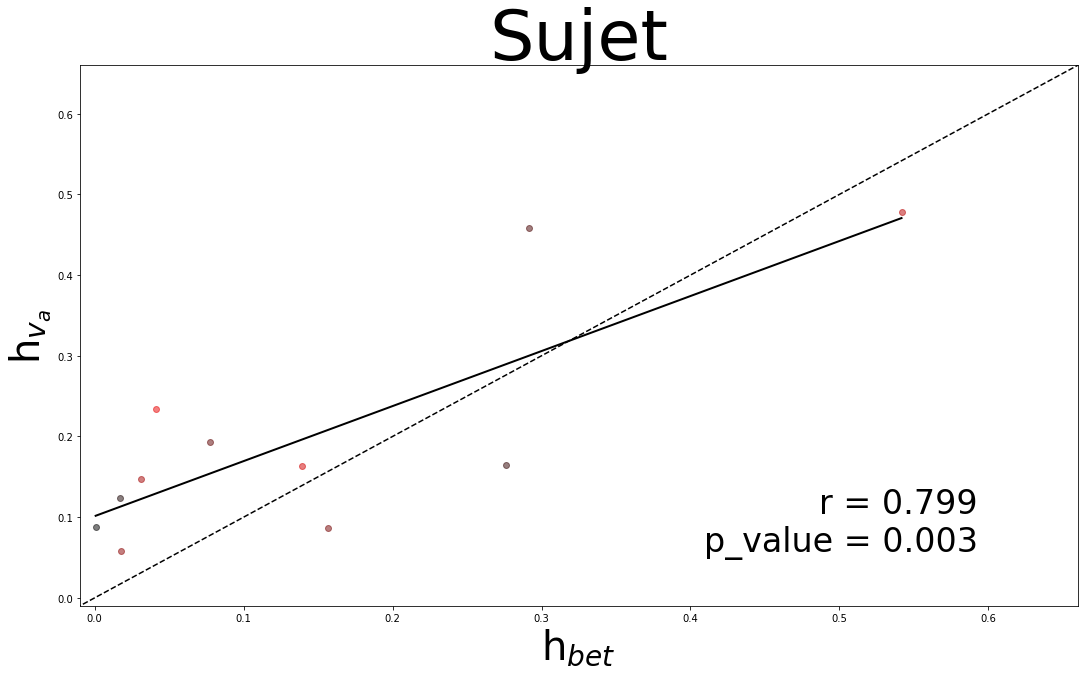

In [18]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

for x, color in enumerate(COLOR):
    axs.scatter(h_bet['sujet'][x], h_va['sujet'][x],color=color)

axs.set_title('Sujet', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,0.66,-0.01,0.66])

regress(axs, h_bet['sujet'], h_va['sujet'], 'k', minx=-0.01, miny=-0.01, maxx=0.66, maxy=0.66)

axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

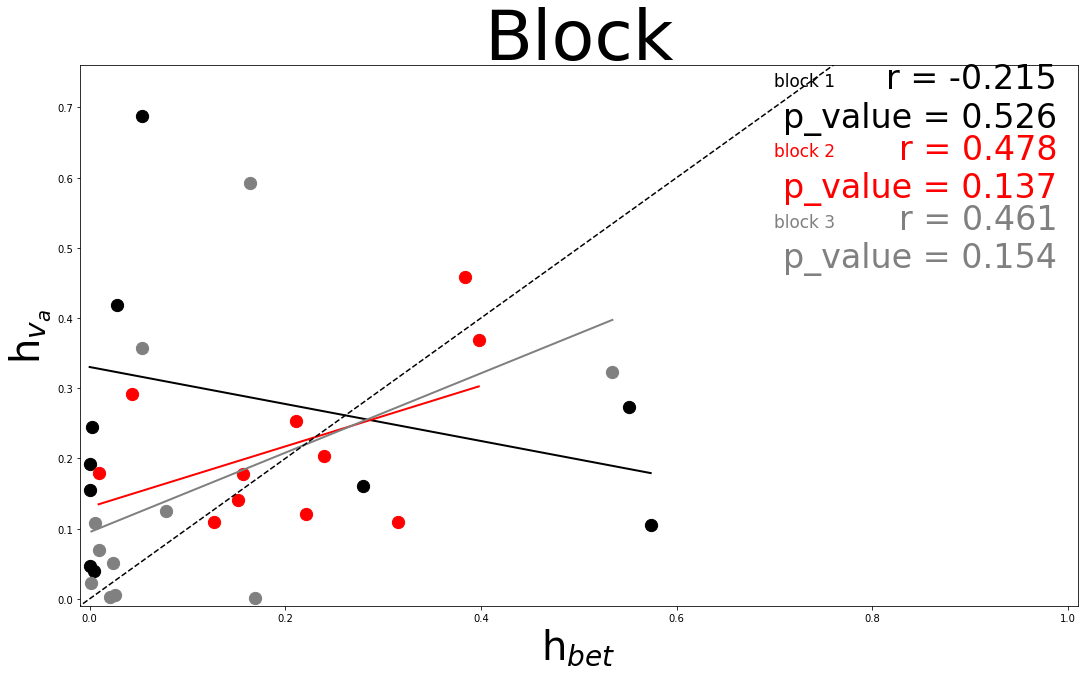

In [19]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

c = ['k', 'r', 'grey']

h_bet_block = []
h_va_block = []

for x, color in enumerate(COLOR):
    for a in range(len(h_bet['block'][x])) :
        axs.scatter(h_bet['block'][x][a], h_va['block'][x][a],color=c[a], s=150)
        if x==0:
            h_bet_block.append([])
            h_va_block.append([])
        h_bet_block[a].append(h_bet['block'][x][a])
        h_va_block[a].append(h_va['block'][x][a])

for a in range(len(h_bet_block)) :
    axs.text(0.7, 0.76-(0.1*(a)+((0.1*(a+3)-0.1*(a))/10)), 'block %s'%(a+1), color=c[a], fontsize=17)
    axs=regress(axs, h_bet_block[a], h_va_block[a], c[a], minx=-0.01, miny=0.7-(0.1*(a)), maxx=1.1, maxy=0.71-(0.1*(a+3)))

axs.set_title('Block', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,1.01,-0.01,0.76])

axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

Moyenne par block


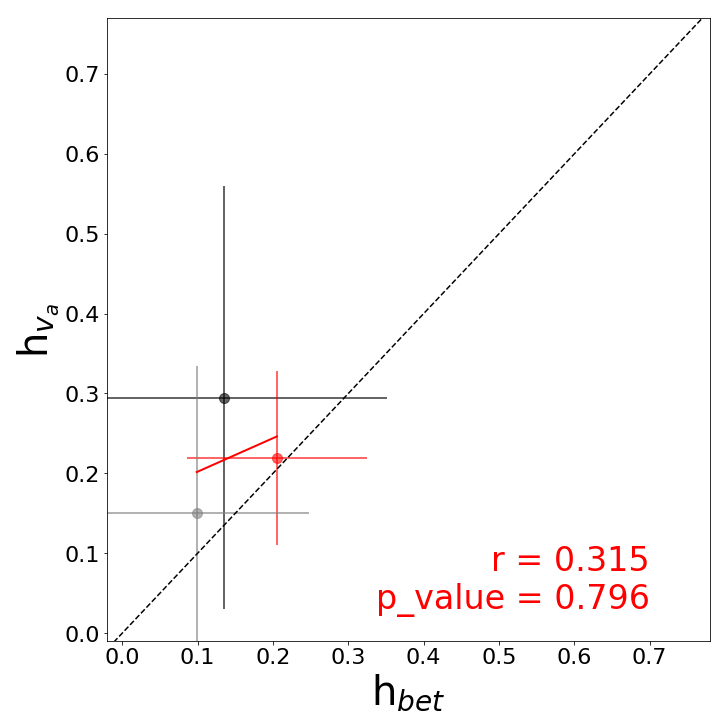

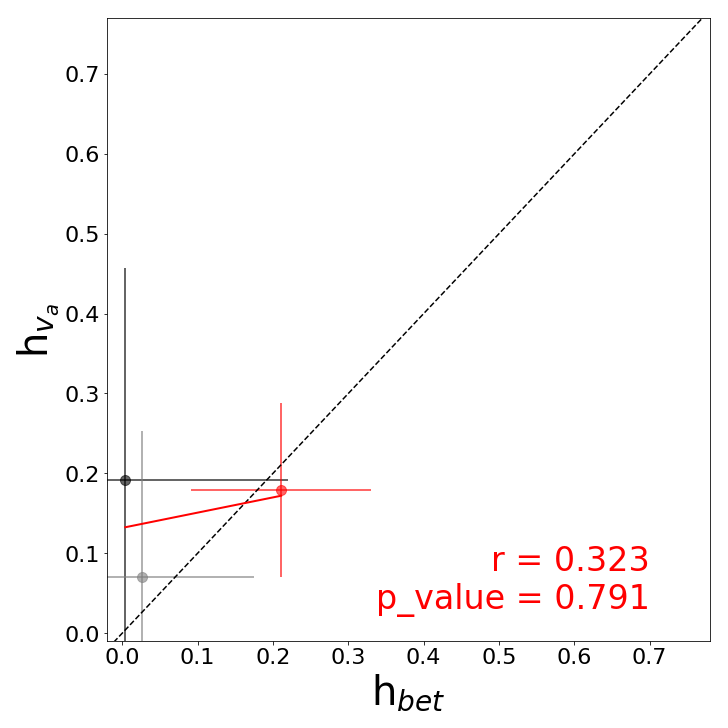

In [20]:
print('Moyenne par block')
fig, axs = scatter_mean(h_bet_block, h_va_block, '', maxx=0.76, maxy=0.76, color=c)
fig, axs = scatter_mean(h_bet_block, h_va_block, '', maxx=0.76, maxy=0.76, mean='mediane', color=c)

#fig1, axs1 = scatter_mean(h_bet_block, h_va_block, '', maxx=0.1, maxy=0.1, ellipse=True)

Moyenne par Sujet block


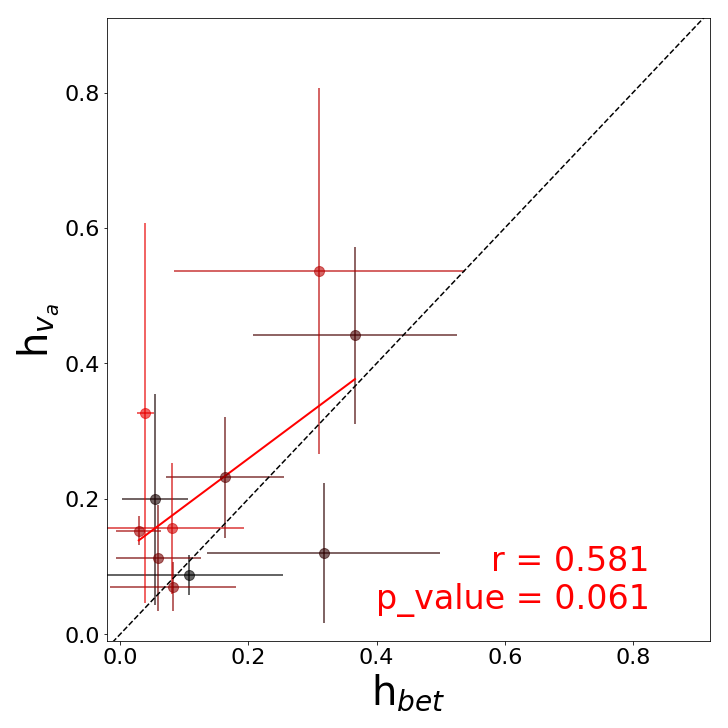

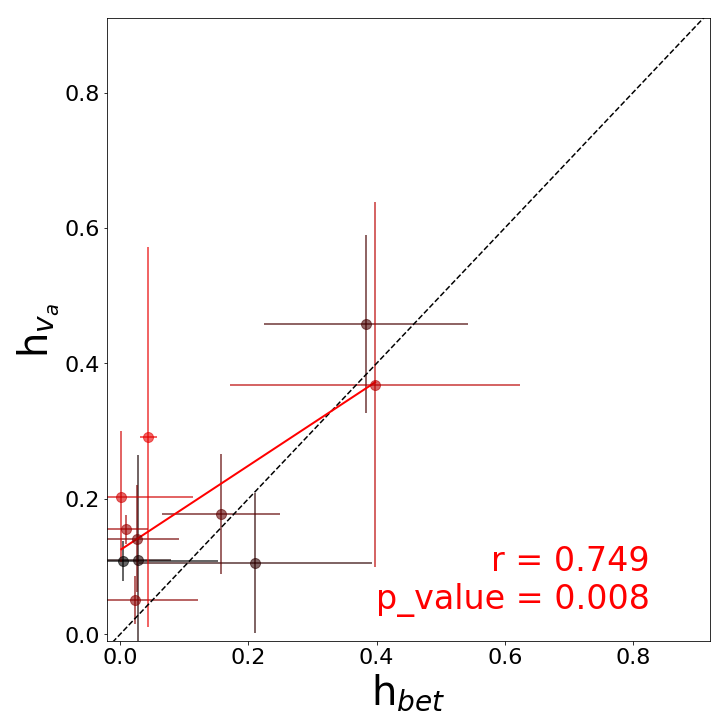

In [21]:
print('Moyenne par Sujet block')
fig, axs = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.9, maxy=0.9, supp=True, color=COLOR)
#for ext in exts: fig.savefig('ms/figures/5_inter-individual_differences_fit' + ext, dpi=400)

fig, axs = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.9, maxy=0.9, mean='mediane', supp=True, color=COLOR)

##fig1, axs1 = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.4, maxy=0.1, ellipse=True)

Moyenne par Sujet pause


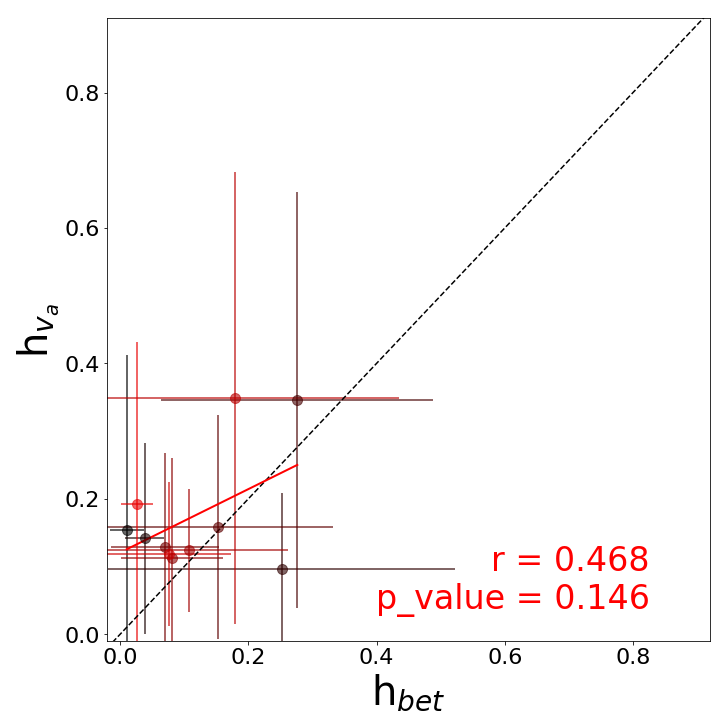

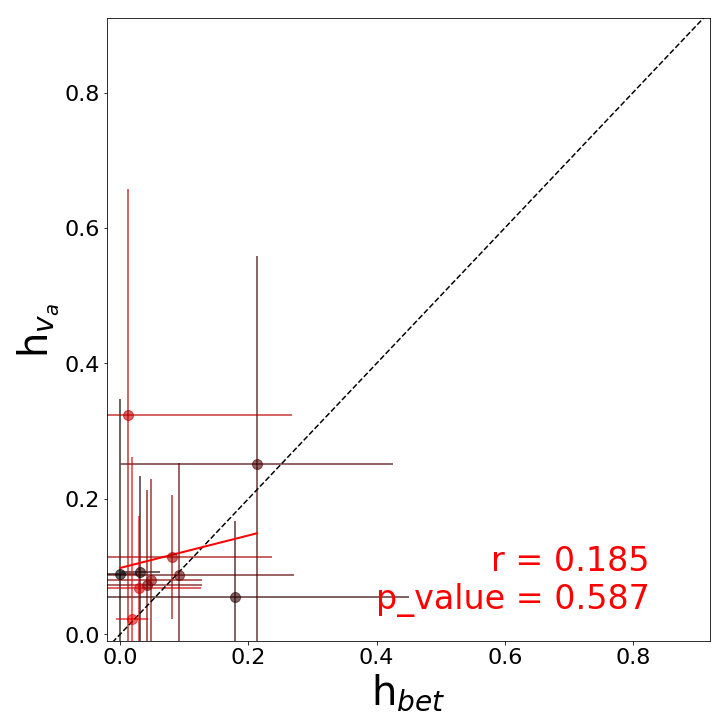

In [22]:
print('Moyenne par Sujet pause')
fig, axs = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.9, maxy=0.9, color=COLOR)
fig, axs = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.9, maxy=0.9, mean='mediane', color=COLOR)
##fig1, axs1 = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.4, maxy=0.4, ellipse=True)

## MI